In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, CalibrationError, SumMetric, Accuracy
import wandb
from utils_datamodel.wandb_utils import load_model, parse_runs, wandb_table_to_dataframe
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from src.plot import plot_subspace, exclude_project_code_dirs, run_metrics_on_samples

from src.ess import SemiSubEllipticalSliceSampling
import os
from src.semi_sub_utils import get_curve_space_torch, span_space_from_curve_model
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from tqdm.notebook import tqdm
from functools import partial
import pyro.distributions as dist
from sklearn.model_selection import StratifiedKFold
from numpyro.diagnostics import summary
from src.semi_sub_utils import features, get_ds_test_from_df, get_ds_from_df, base_net_kwargs
from src.semi_subspace import *
from utils_datamodel.utils import FastFillTensorDataLoader
import arviz as az
from statsmodels.stats.proportion import proportion_confint

# %load_ext tensorboard
sns.set_style("whitegrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./simulation.ipynb
%env WANDB_SILENT=True

wandb_project = 'semiSub_simulation1_coverage_test'
use_ortho = False
seed = 0

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]

fig_width_pt = 487.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize_l = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)



Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./simulation.ipynb
env: WANDB_SILENT=True
Figure size= [3.2489276324892766, 2.0079477038671003]


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


ASCII color code for printing:
- Red = '\033[91m'
- Green = '\033[92m'
- Blue = '\033[94m'
- Cyan = '\033[96m'
- White = '\033[97m'
- Yellow = '\033[93m'
- Magenta = '\033[95m'
- Grey = '\033[90m'
- Black = '\033[90m'
- Default = '\033[99m'

## V2 Compare Sampler and subspace dimensionality using stats metrics

In [72]:
from collections import OrderedDict
from scipy.stats import skew, kurtosis
from scipy.stats import gaussian_kde

diff_stats = []
# seeds = []
exp_names = [2,4,8,12,16]
project_names = ["ddold/semiSub_simulation_coverage_hmc_sub_d2",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d4",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d8",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d12",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d16"]
struct_labels = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$']

In [45]:
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    all_samples_subspace = OrderedDict()
    runs_cnt = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "SemiSub"})):
        exp_id = r.name.split('_')[-1]
        runs_cnt.append(i)
        # seeds[exp_id] = r.config['seed']
        print(f"Load exp {r.name}: id {exp_id}")
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_subspace[exp_id] = samples_theta
    all_samples_hmc = OrderedDict()
    for r in wandb.Api().runs(path=project, filters={"group": "HMC"}):
        exp_id = r.name.split('_')[-1]
        print(f"Load exp {r.name}: id {exp_id}")
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_hmc[exp_id] = samples_theta

    exp_ids = []
    mean_divs = []
    median_divs = []
    std_divs = []
    skew_divs = []
    kurtosis_divs = []
    seed_list = []

    for run_cnt, (exp_id, samples_subspace) in  zip(runs_cnt, all_samples_subspace.items()):
        samples_hmc = all_samples_hmc[exp_id]
        samples_hmc = samples_hmc.reshape(-1, 3)
        samples_subspace = samples_subspace.reshape(-1, 3)

        exp_ids.append(exp_id)

        # Compute mean and median difference
        mean_div = samples_subspace.mean(0)-samples_hmc.mean(0)
        mean_divs.append(mean_div)

        median_div = np.median(samples_subspace, axis=0)-np.median(samples_hmc, axis=0)
        median_divs.append(median_div)

        std_div = samples_subspace.std(0)-samples_hmc.std(0)
        std_divs.append(std_div)

        skew_div = skew(samples_subspace, axis=0)-skew(samples_hmc, axis=0)
        skew_divs.append(skew_div)

        kurtosis_div = kurtosis(samples_subspace, axis=0)-kurtosis(samples_hmc, axis=0)
        kurtosis_divs.append(kurtosis_div)

    df_mean = pd.DataFrame(mean_divs, index=exp_ids, columns=struct_labels)
    df_median = pd.DataFrame(median_divs, index=exp_ids, columns=struct_labels)
    df_std = pd.DataFrame(std_divs, index=exp_ids, columns=struct_labels)
    df_skew = pd.DataFrame(skew_divs, index=exp_ids, columns=struct_labels)
    df_kurtosis = pd.DataFrame(kurtosis_divs, index=exp_ids, columns=struct_labels)

    df = pd.concat([df_mean, df_median, df_std, df_skew, df_kurtosis], axis=1,
                   keys=[r"$\Delta$ Mean", r"$\Delta$ Median", r"$\Delta$ Std", r"$\Delta$ Skew", r"$\Delta$ Kurtosis"])
    df_run = pd.Series(runs_cnt, index=df.index, name='Run')
    df = df.stack(1).reset_index(level=1).join(df_run)
    df = df.reset_index().rename(columns={'level_0':'exp_id', 'level_1':'Parameter'})
    df['Dimension'] = exp_name
    diff_stats.append(df)

diff_stats
num_parameters_full_space = np.sum([np.prod(samples.posterior[var_name].to_numpy().shape[2:]) for var_name in samples.posterior.data_vars])

Load project ddold/semiSub_simulation_coverage_hmc_sub_d2
Load exp ess_from_82mr5hgg: id 82mr5hgg
Load exp ess_from_wlu3jc2f: id wlu3jc2f
Load exp ess_from_lfmwq8q9: id lfmwq8q9
Load exp ess_from_xngnoatp: id xngnoatp
Load exp ess_from_lxo9fvgw: id lxo9fvgw
Load exp ess_from_f2n9ce1k: id f2n9ce1k
Load exp ess_from_6qbz7ahm: id 6qbz7ahm
Load exp ess_from_rpucymay: id rpucymay
Load exp ess_from_778ho5q1: id 778ho5q1
Load exp ess_from_pxvenpt5: id pxvenpt5
Load exp ess_from_rinxox3x: id rinxox3x
Load exp ess_from_dqv2uz9f: id dqv2uz9f
Load exp ess_from_td8d3hdt: id td8d3hdt
Load exp ess_from_k7jr576x: id k7jr576x
Load exp ess_from_ndahpog3: id ndahpog3
Load exp ess_from_li76w22y: id li76w22y
Load exp ess_from_lgrlnqvw: id lgrlnqvw
Load exp ess_from_y3ph54jz: id y3ph54jz
Load exp ess_from_8mz9ewo3: id 8mz9ewo3
Load exp ess_from_gf3dty2c: id gf3dty2c
Load exp ess_from_d9nzo9ug: id d9nzo9ug
Load exp ess_from_f0y6c1bk: id f0y6c1bk
Load exp ess_from_zvscvi1y: id zvscvi1y
Load exp ess_from_eltn

### compare moments

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2'),
  Text(1, 0, '4'),
  Text(2, 0, '8'),
  Text(3, 0, '12'),
  Text(4, 0, '16')])

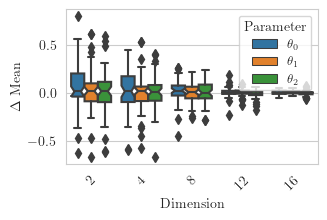

In [46]:
sns.boxplot(pd.concat(diff_stats), y='$\Delta$ Mean', x='Dimension', hue='Parameter', notch=True)
plt.xticks(rotation=45)

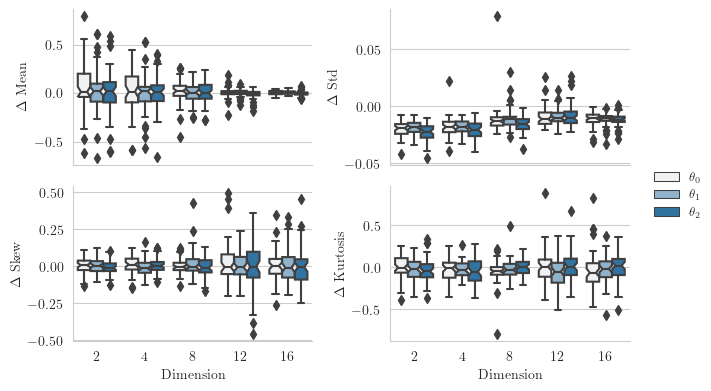

In [49]:
diff_stats_filter = pd.concat(diff_stats).melt(id_vars=['index', 'Parameter', 'Run', 'Dimension'], var_name='Stat')
diff_stats_filter = diff_stats_filter[diff_stats_filter['Stat'] != r'$\Delta$ Median']
g = sns.FacetGrid(diff_stats_filter, col='Stat', col_wrap=2, sharey=False, margin_titles=True, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_dataframe(sns.boxplot, y='value', x='Dimension', hue='Parameter', notch=True)
g.add_legend()
for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_title().split('=')[-1])
    ax.set_title('')
g.tight_layout()
plt.savefig("figures2/Simulation_stats_Normal.pdf", bbox_inches='tight')

### compare lppd

$lppd = \sum^N_{i=1} log ( \sum^S_{s=1} p(y_i|\theta_s))$


Load project ddold/semiSub_simulation_coverage_hmc_sub_d2


Load project ddold/semiSub_simulation_coverage_hmc_sub_d4
Load project ddold/semiSub_simulation_coverage_hmc_sub_d8
Load project ddold/semiSub_simulation_coverage_hmc_sub_d12
Load project ddold/semiSub_simulation_coverage_hmc_sub_d16


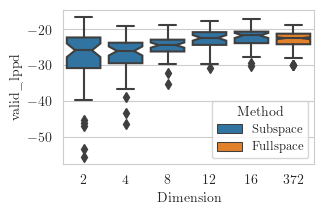

In [50]:
df_lppd = []
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    valid_lppds = []
    test_lppds = []
    exp_ids = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "SemiSub"})):
        valid_lppds.append(r.summary['valid_lppd'])
        test_lppds.append(r.summary['test_lppd'])
        exp_ids.append(r.name.split('_')[-1])
    df_lppd_sub = pd.DataFrame(np.vstack([valid_lppds,test_lppds,exp_ids]).T, columns=['valid_lppd', 'test_lppd', 'exp_id'])
    df_lppd_sub['Method'] = 'Subspace'
    df_lppd_sub["Dimension"] = exp_name
    valid_lppds = []
    test_lppds = []
    exp_ids = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "HMC"})):
        valid_lppds.append(r.summary['valid_lppd'])
        test_lppds.append(r.summary['test_lppd'])
        exp_ids.append(r.name.split('_')[-1])
    df_lppd_hmc = pd.DataFrame(np.vstack([valid_lppds,test_lppds,exp_ids]).T, columns=['valid_lppd', 'test_lppd', 'exp_id'])
    df_lppd_hmc['Method'] = 'Fullspace'
    df_lppd_hmc['Dimension'] = num_parameters_full_space
    df = pd.concat([df_lppd_sub, df_lppd_hmc])
    df_lppd.append(df)
df_lppd = pd.concat(df_lppd)
df_lppd['valid_lppd'] = pd.to_numeric(df_lppd['valid_lppd'])
df_lppd['test_lppd'] = pd.to_numeric(df_lppd['test_lppd'])

ax = sns.boxplot(df_lppd, x='Dimension', y='valid_lppd', hue="Method", notch=True, dodge=False)

<Axes: xlabel='Dimension', ylabel='test_lppd'>

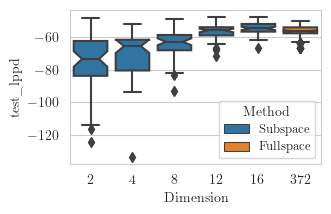

In [51]:
sns.boxplot(df_lppd, x='Dimension', y='test_lppd', hue="Method", notch=True, dodge=False)

### compare Calibration

In [73]:
df_cis = []
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    run_qq_plot = list(wandb.Api().runs(path=project, filters={"display_name": "qq_plot"}))[0]
    for art in run_qq_plot.logged_artifacts():
        filename = art.file().split('/')[-1]
        table = art.get(filename)
        df = pd.DataFrame(table.data, columns=table.columns)
        df['Space'] = 'Fullspace' if "hmc" in filename else "Subspace"
        df['Dimension'] = exp_name
        df_cis.append(df)
df_cis = pd.concat(df_cis)
# for k, df_ci_ in df_cis.items():
#     fig = plt.figure(figsize=(5., 5.), dpi=100)
#     df_ci_ = df_ci_.groupby('alpha').mean()
#     df_ci_.drop(columns='run', inplace=True)
#     df_ci_ = df_ci_.reset_index().melt(id_vars=['alpha'], var_name='parameter')
#     ax = sns.lineplot(df_ci_, x='alpha', y='value', hue='parameter', markers=True, dashes=False)
#     ax.set_xlim(0, 1.)
#     ax.set_ylim(0, 1.)
#     ax.plot([0, 1], [0, 1], '--k', alpha=0.8)
#     plt.title(k.split('.')[0])

Load project ddold/semiSub_simulation_coverage_hmc_sub_d2


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_d4


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_d8


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_d12


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_d16


wandb:   1 of 1 files downloaded.  


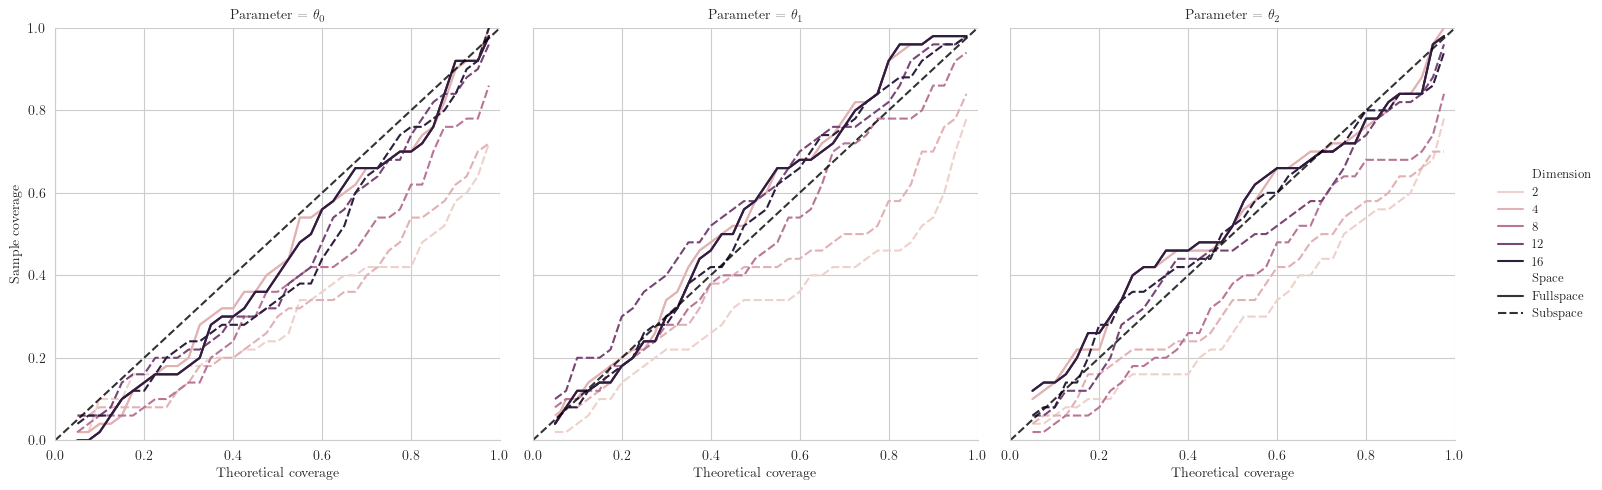

In [74]:
df_cis_ = df_cis.groupby(["alpha", "Space", "Dimension"]).mean()
df_cis_.drop(columns="run", inplace=True)
df_cis_ = df_cis_.melt(ignore_index=False, var_name="Parameter", value_name="Sample coverage")
df_cis_.index.rename({'alpha': 'Theoretical coverage'}, inplace=True)
g = sns.FacetGrid(df_cis_.reset_index(), col="Parameter", aspect=1, height=5)
g.map_dataframe(sns.lineplot, x="Theoretical coverage", y="Sample coverage", hue="Dimension", style="Space", hue_order=["ESS 2", "2", "4", "10", "19"])
g.add_legend()
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.)
    ax.plot([0, 1], [0, 1], '--k', alpha=0.8)
g.tight_layout()
for ax in g.axes.flatten():
    ax.set_yticks(ax.get_xticks())

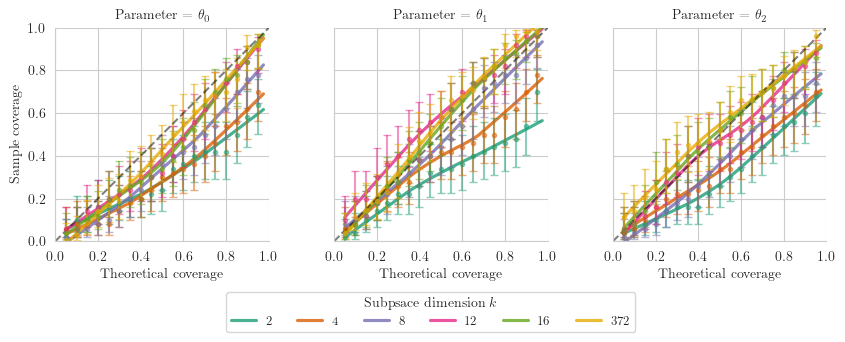

In [75]:
N = df_cis['run'].max() + 1
df_cis_hmc = df_cis[df_cis['Space'] == "Fullspace"].drop(columns="Dimension").groupby(["alpha", "Space"]).mean().reset_index()
df_cis_hmc['Dimension'] = num_parameters_full_space
df_cis_space = df_cis[df_cis['Space'] == "Subspace"].groupby(["alpha", "Space", "Dimension"]).mean().reset_index()
df_cis_ = pd.concat([df_cis_hmc,df_cis_space])
df_cis_.drop(columns="run", inplace=True)
df_cis_ = df_cis_.melt(id_vars=["alpha", "Space", "Dimension"], var_name="Parameter", value_name="Sample coverage")
df_cis_.rename(columns={'alpha': 'Theoretical coverage'}, inplace=True)
lower_bound, upper_bound = proportion_confint(count=df_cis_['Sample coverage']*N, nobs=N, method='wilson', alpha=0.05)
df_cis_['CI lower'] = lower_bound
df_cis_['CI upper'] = upper_bound
# df_cis_ = df_cis_[df_cis_['Parameter'] == r'$\theta_{1}$']
df_cis_.rename(columns={'Dimension':r'$k=$'}, inplace=True)
g = sns.lmplot(df_cis_, col="Parameter", aspect=1, height=figsize[1]*1.5, x="Theoretical coverage", y="Sample coverage", hue=r'$k=$', hue_order=[2,4,8,12,16, num_parameters_full_space], palette=sns.color_palette("Dark2"), lowess=True, scatter=False, legend=False, line_kws={'alpha':0.8})
# g.add_legend(loc='upper right')
for ax, (parameter, df) in zip(g.axes.flatten(), df_cis_.groupby('Parameter')):
    ax.set_aspect(1)
    # ax.legend(loc="upper left",bbox_to_anchor=(1.1, .95,), title=r"$k$=")
    for i, (dim, df) in enumerate(df.groupby(r'$k=$')):
        conf_interval = (df['CI lower'].to_numpy(), df['CI upper'].to_numpy())
        y = df['Sample coverage'].to_numpy()
        ax.errorbar(x=df['Theoretical coverage'].to_numpy()[::2], y=y[::2], yerr=((y-conf_interval[0])[::2], (conf_interval[1]-y)[::2]), alpha=0.5, fmt='o', capsize=3, markersize=3, color=sns.color_palette("Dark2")[i])
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.)
    ax.plot([0, 1], [0, 1], '--k', alpha=0.5)
for ax in g.axes.flatten():
    ax.set_yticks(ax.get_xticks())
plt.gcf().legend(*g.axes[0,0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5, -0.14,), ncols=6, title=r"Subpsace dimension $k$")
# plt.gcf().legend(loc="upper left",bbox_to_anchor=(0.9, .95,), title=r"$k$=")
# g.add_legend()
g.tight_layout()
plt.savefig("figures2/simulation_coverage_comp_Normal.pdf",bbox_inches='tight')


## V2 Compare Poisson

In [76]:
from collections import OrderedDict
from scipy.stats import skew, kurtosis
from scipy.stats import gaussian_kde

diff_stats = []
# seeds = []
exp_names = [2, 4, 8, 12, 16]
project_names = ["ddold/semiSub_simulation_coverage_hmc_sub_P_d2_v4",
                "ddold/semiSub_simulation_coverage_hmc_sub_P_d4",
                "ddold/semiSub_simulation_coverage_hmc_sub_P_d8",
                "ddold/semiSub_simulation_coverage_hmc_sub_P_d12",
                "ddold/semiSub_simulation_coverage_hmc_sub_P_d16"]
struct_labels = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$']
num_parameters_full_space = 372

In [27]:

qq_plot_data_id = []
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    all_samples_subspace = OrderedDict()
    runs_cnt = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "SemiSub"})):
        exp_id = r.name.split('_')[-1]
        runs_cnt.append(i)
        # seeds[exp_id] = r.config['seed']
        print(f"Load exp {r.name}: id {exp_id}")
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_subspace[exp_id] = samples_theta
    all_samples_hmc = OrderedDict()
    for r in wandb.Api().runs(path=project, filters={"group": "HMC"}):
        exp_id = r.name.split('_')[-1]
        print(f"Load exp {r.name}: id {exp_id}")
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_hmc[exp_id] = samples_theta

    exp_ids = []
    mean_divs = []
    median_divs = []
    std_divs = []
    skew_divs = []
    kurtosis_divs = []
    seed_list = []

    for run_cnt, (exp_id, samples_subspace) in  zip(runs_cnt, all_samples_subspace.items()):
        samples_hmc = all_samples_hmc[exp_id]
        samples_hmc = samples_hmc.reshape(-1, 3)
        samples_subspace = samples_subspace.reshape(-1, 3)

        exp_ids.append(exp_id)

        # Compute mean and median difference
        mean_div = samples_subspace.mean(0)-samples_hmc.mean(0)
        mean_divs.append(mean_div)

        median_div = np.median(samples_subspace, axis=0)-np.median(samples_hmc, axis=0)
        median_divs.append(median_div)

        std_div = samples_subspace.std(0)-samples_hmc.std(0)
        std_divs.append(std_div)

        skew_div = skew(samples_subspace, axis=0)-skew(samples_hmc, axis=0)
        skew_divs.append(skew_div)

        kurtosis_div = kurtosis(samples_subspace, axis=0)-kurtosis(samples_hmc, axis=0)
        kurtosis_divs.append(kurtosis_div)

    df_mean = pd.DataFrame(mean_divs, index=exp_ids, columns=struct_labels)
    df_median = pd.DataFrame(median_divs, index=exp_ids, columns=struct_labels)
    df_std = pd.DataFrame(std_divs, index=exp_ids, columns=struct_labels)
    df_skew = pd.DataFrame(skew_divs, index=exp_ids, columns=struct_labels)
    df_kurtosis = pd.DataFrame(kurtosis_divs, index=exp_ids, columns=struct_labels)

    df = pd.concat([df_mean, df_median, df_std, df_skew, df_kurtosis], axis=1,
                   keys=[r"$\Delta$ Mean", r"$\Delta$ Median", r"$\Delta$ Std", r"$\Delta$ Skew", r"$\Delta$ Kurtosis"])
    df_run = pd.Series(runs_cnt, index=df.index, name='Run')
    df = df.stack(1).reset_index(level=1).join(df_run)
    df = df.reset_index().rename(columns={'level_0':'exp_id', 'level_1':'Parameter'})
    df['Dimension'] = exp_name
    diff_stats.append(df)

diff_stats
num_parameters_full_space = np.sum([np.prod(samples.posterior[var_name].to_numpy().shape[2:]) for var_name in samples.posterior.data_vars])

Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d2_v4
Load exp ess_from_ifp9jk6c: id ifp9jk6c
Load exp ess_from_xl6aex5y: id xl6aex5y
Load exp ess_from_6vd8xh11: id 6vd8xh11
Load exp ess_from_f4033kha: id f4033kha
Load exp ess_from_704m0ba1: id 704m0ba1
Load exp ess_from_2aoj78r9: id 2aoj78r9
Load exp ess_from_1r3aegoq: id 1r3aegoq
Load exp ess_from_c52tin8f: id c52tin8f
Load exp ess_from_lxl5dz46: id lxl5dz46
Load exp ess_from_mw7jypi9: id mw7jypi9
Load exp ess_from_1kuceywa: id 1kuceywa
Load exp ess_from_5ldjr9gl: id 5ldjr9gl
Load exp ess_from_ox1c926u: id ox1c926u
Load exp ess_from_k7xo69hy: id k7xo69hy
Load exp ess_from_ylm0d0se: id ylm0d0se
Load exp ess_from_gkb8z3yr: id gkb8z3yr
Load exp ess_from_oz4k7l0g: id oz4k7l0g
Load exp ess_from_a9tvj78c: id a9tvj78c
Load exp ess_from_4o77n544: id 4o77n544
Load exp ess_from_52r2x2a0: id 52r2x2a0
Load exp ess_from_sue5d5o5: id sue5d5o5
Load exp ess_from_a350i8jk: id a350i8jk
Load exp ess_from_xlpj426i: id xlpj426i
Load exp ess_from

### compare moments

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2'),
  Text(1, 0, '4'),
  Text(2, 0, '8'),
  Text(3, 0, '12'),
  Text(4, 0, '16')])

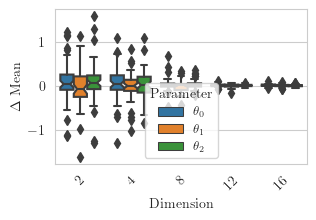

In [28]:
sns.boxplot(pd.concat(diff_stats), y='$\Delta$ Mean', x='Dimension', hue='Parameter', notch=True)
plt.xticks(rotation=45)

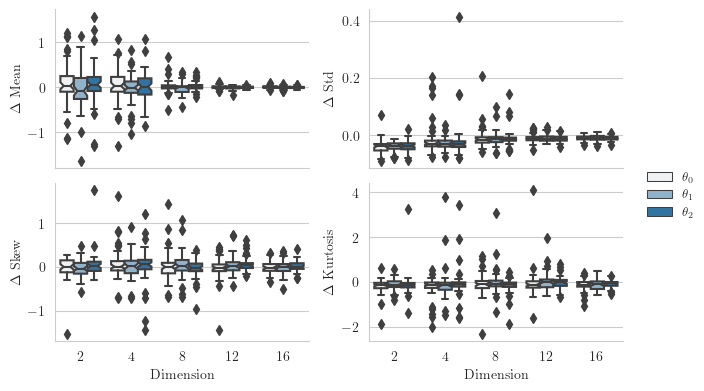

In [39]:
diff_stats_filter = pd.concat(diff_stats).melt(id_vars=['index', 'Parameter', 'Run', 'Dimension'], var_name='Stat')
diff_stats_filter = diff_stats_filter[diff_stats_filter['Stat'] != r'$\Delta$ Median']
g = sns.FacetGrid(diff_stats_filter, col='Stat', col_wrap=2, sharey=False, margin_titles=True, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_dataframe(sns.boxplot, y='value', x='Dimension', hue='Parameter', notch=True)
g.add_legend()
for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_title().split('=')[-1])
    ax.set_title('')
g.tight_layout()
plt.savefig("figures2/Simulation_stats_Poisson.pdf", bbox_inches='tight')

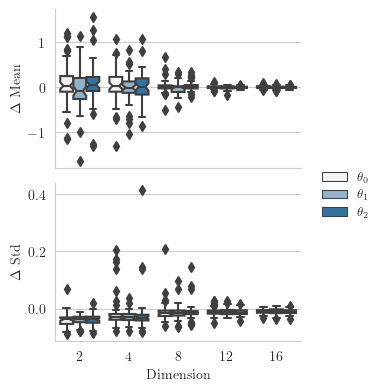

In [30]:
diff_stats_filter = pd.concat(diff_stats).melt(id_vars=['index', 'Parameter', 'Run', 'Dimension'], var_name='Stat')
diff_stats_filter = diff_stats_filter[(diff_stats_filter['Stat'] != r'$\Delta$ Median') &
                                      (diff_stats_filter['Stat'] != r'$\Delta$ Skew') &
                                      (diff_stats_filter['Stat'] != r'$\Delta$ Kurtosis')]
g = sns.FacetGrid(diff_stats_filter, col='Stat', col_wrap=1, sharey=False, margin_titles=True, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_dataframe(sns.boxplot, y='value', x='Dimension', hue='Parameter', notch=True)
g.add_legend()
for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_title().split('=')[-1])
    ax.set_title('')
g.tight_layout()
plt.savefig("figures2/poisson_stat_compare.pdf")

### compare lppd

Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d2_v4


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d4
Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d8
Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d12
Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d16


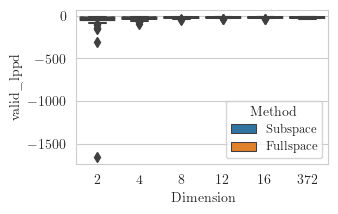

In [31]:
df_lppd = []
struct_labels = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$']
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    valid_lppds = []
    test_lppds = []
    exp_ids = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "SemiSub"})):
        valid_lppds.append(r.summary['valid_lppd'])
        test_lppds.append(r.summary['test_lppd'])
        exp_ids.append(r.name.split('_')[-1])
    df_lppd_sub = pd.DataFrame(np.vstack([valid_lppds,test_lppds,exp_ids]).T, columns=['valid_lppd', 'test_lppd', 'exp_id'])
    df_lppd_sub['Method'] = 'Subspace'
    df_lppd_sub["Dimension"] = exp_name
    valid_lppds = []
    test_lppds = []
    exp_ids = []
    for i, r in enumerate(wandb.Api().runs(path=project, filters={"group": "HMC"})):
        valid_lppds.append(r.summary['valid_lppd'])
        test_lppds.append(r.summary['test_lppd'])
        exp_ids.append(r.name.split('_')[-1])
    df_lppd_hmc = pd.DataFrame(np.vstack([valid_lppds,test_lppds,exp_ids]).T, columns=['valid_lppd', 'test_lppd', 'exp_id'])
    df_lppd_hmc['Method'] = 'Fullspace'
    df_lppd_hmc['Dimension'] = num_parameters_full_space
    df = pd.concat([df_lppd_sub, df_lppd_hmc])
    df_lppd.append(df)
df_lppd = pd.concat(df_lppd)
df_lppd['valid_lppd'] = pd.to_numeric(df_lppd['valid_lppd'])
df_lppd['test_lppd'] = pd.to_numeric(df_lppd['test_lppd'])

ax = sns.boxplot(df_lppd, x='Dimension', y='valid_lppd', hue="Method", notch=True, dodge=False)

<Axes: xlabel='Dimension', ylabel='test_lppd'>

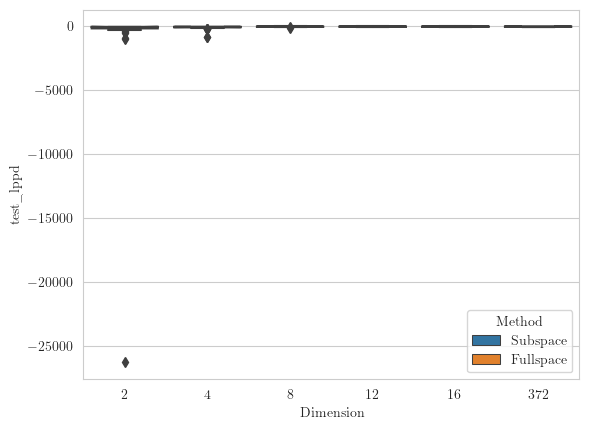

In [27]:
sns.boxplot(df_lppd, x='Dimension', y='test_lppd', hue="Method", notch=True, dodge=False)

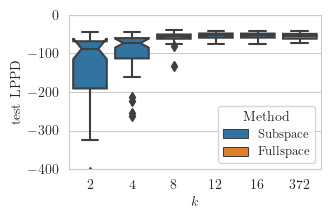

In [37]:
sns.boxplot(df_lppd, x='Dimension', y='test_lppd', hue="Method", notch=True, dodge=False)
plt.ylim(bottom=-400, top=0)
plt.ylabel("test LPPD")
plt.xlabel(r"$k$")
plt.savefig("figures2/SimulationTestLPPD_Poisson")

### compare Calibration

In [77]:
struct_labels = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$']
df_cis = []
for exp_name, project in zip(exp_names, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    run_qq_plot = list(wandb.Api().runs(path=project, filters={"display_name": "qq_plot"}))[0]
    for art in run_qq_plot.logged_artifacts():
        filename = art.file().split('/')[-1]
        table = art.get(filename)
        df = pd.DataFrame(table.data, columns=table.columns)
        df['Space'] = 'Fullspace' if "hmc" in filename else "Subspace"
        df['Dimension'] = exp_name
        df_cis.append(df)
df_cis = pd.concat(df_cis)

wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d2_v4


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d4


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d8


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d12


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Load project ddold/semiSub_simulation_coverage_hmc_sub_P_d16


wandb:   1 of 1 files downloaded.  


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)


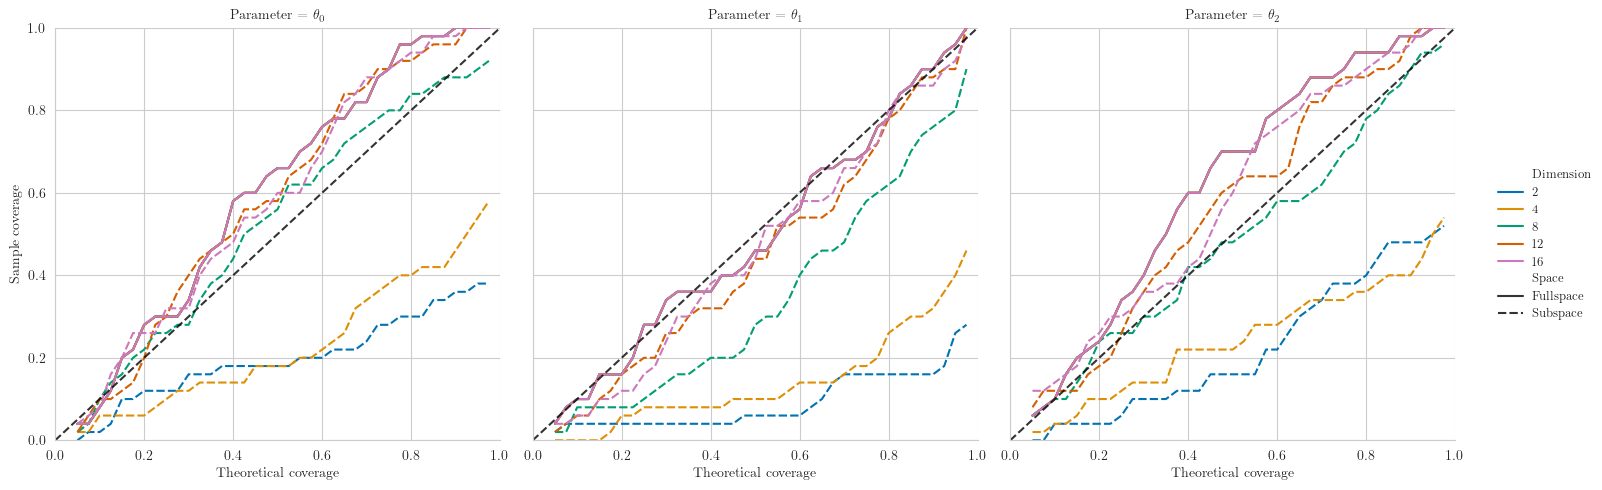

In [78]:
df_cis_ = df_cis.groupby(["alpha", "Space", "Dimension"]).mean()
df_cis_.drop(columns="run", inplace=True)
df_cis_ = df_cis_.melt(ignore_index=False, var_name="Parameter", value_name="Sample coverage")
df_cis_.index.rename({'alpha': 'Theoretical coverage'}, inplace=True)
g = sns.FacetGrid(df_cis_.reset_index(), col="Parameter", aspect=1, height=5)
g.map_dataframe(sns.lineplot, x="Theoretical coverage", y="Sample coverage", hue="Dimension", style="Space", hue_order=[2,4,8,12,16], palette=sns.color_palette('colorblind'))
g.add_legend()
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.)
    ax.plot([0, 1], [0, 1], '--k', alpha=0.8)
g.tight_layout()
for ax in g.axes.flatten():
    ax.set_yticks(ax.get_xticks())

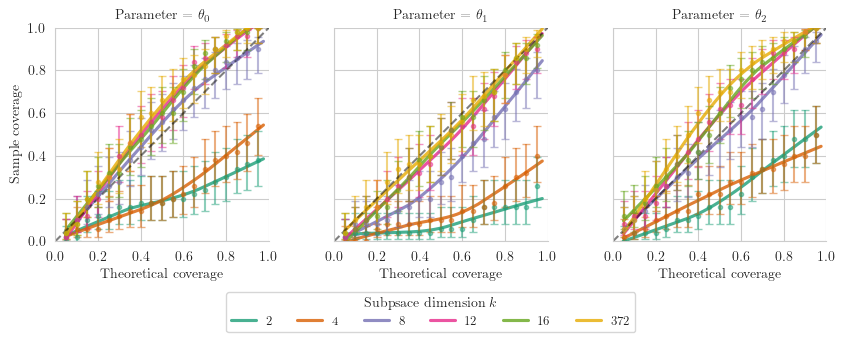

In [71]:
N = df_cis['run'].max() + 1
df_cis_hmc = df_cis[df_cis['Space'] == "Fullspace"].drop(columns="Dimension").groupby(["alpha", "Space"]).mean().reset_index()
df_cis_hmc['Dimension'] = num_parameters_full_space
df_cis_space = df_cis[df_cis['Space'] == "Subspace"].groupby(["alpha", "Space", "Dimension"]).mean().reset_index()
df_cis_ = pd.concat([df_cis_hmc,df_cis_space])
df_cis_.drop(columns="run", inplace=True)
df_cis_ = df_cis_.melt(id_vars=["alpha", "Space", "Dimension"], var_name="Parameter", value_name="Sample coverage")
df_cis_.rename(columns={'alpha': 'Theoretical coverage'}, inplace=True)
lower_bound, upper_bound = proportion_confint(count=df_cis_['Sample coverage']*N, nobs=N, method='wilson', alpha=0.05)
df_cis_['CI lower'] = lower_bound
df_cis_['CI upper'] = upper_bound
# df_cis_ = df_cis_[df_cis_['Parameter'] == r'$\theta_{1}$']
df_cis_.rename(columns={'Dimension':r'$k=$'}, inplace=True)
g = sns.lmplot(df_cis_, col="Parameter", aspect=1, height=figsize[1]*1.5, x="Theoretical coverage", y="Sample coverage", hue=r'$k=$', hue_order=[2,4,8,12,16, num_parameters_full_space], palette=sns.color_palette("Dark2"), lowess=True, scatter=False, legend=False, line_kws={'alpha':0.8})
# g.add_legend(loc='upper right')
for ax, (parameter, df) in zip(g.axes.flatten(), df_cis_.groupby('Parameter')):
    ax.set_aspect(1)
    # ax.legend(loc="upper left",bbox_to_anchor=(1.1, .95,), title=r"$k$=")
    for i, (dim, df) in enumerate(df.groupby(r'$k=$')):
        conf_interval = (df['CI lower'].to_numpy(), df['CI upper'].to_numpy())
        y = df['Sample coverage'].to_numpy()
        ax.errorbar(x=df['Theoretical coverage'].to_numpy()[::2], y=y[::2], yerr=((y-conf_interval[0])[::2], (conf_interval[1]-y)[::2]), alpha=0.5, fmt='o', capsize=3, markersize=3, color=sns.color_palette("Dark2")[i])
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.)
    ax.plot([0, 1], [0, 1], '--k', alpha=0.5)
for ax in g.axes.flatten():
    ax.set_yticks(ax.get_xticks())
# plt.gcf().legend(loc="upper left",bbox_to_anchor=(0.9, .95,), title=r"$k$=")
# g.add_legend()
plt.gcf().legend(*g.axes[0,0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5, -0.14,), ncols=6, title=r"Subpsace dimension $k$")
g.tight_layout()
plt.savefig("figures2/simulation_coverage_comp_Poisson_all.pdf",bbox_inches='tight')

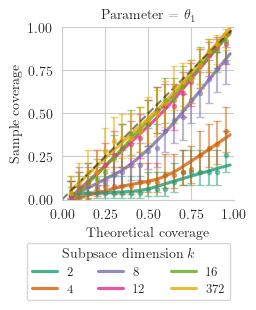

In [84]:
N = df_cis['run'].max() + 1
df_cis_hmc = df_cis[df_cis['Space'] == "Fullspace"].drop(columns="Dimension").groupby(["alpha", "Space"]).mean().reset_index()
df_cis_hmc['Dimension'] = num_parameters_full_space
df_cis_space = df_cis[df_cis['Space'] == "Subspace"].groupby(["alpha", "Space", "Dimension"]).mean().reset_index()
df_cis_ = pd.concat([df_cis_hmc,df_cis_space])
df_cis_.drop(columns="run", inplace=True)
df_cis_ = df_cis_.melt(id_vars=["alpha", "Space", "Dimension"], var_name="Parameter", value_name="Sample coverage")
df_cis_.rename(columns={'alpha': 'Theoretical coverage'}, inplace=True)
lower_bound, upper_bound = proportion_confint(count=df_cis_['Sample coverage']*N, nobs=N, method='wilson', alpha=0.05)
df_cis_['CI lower'] = lower_bound
df_cis_['CI upper'] = upper_bound
df_cis_ = df_cis_[df_cis_['Parameter'] == r'$\theta_{1}$']
df_cis_.rename(columns={'Dimension':r'$k=$'}, inplace=True)
g = sns.lmplot(df_cis_, col="Parameter", aspect=1, height=figsize[0]*0.8, x="Theoretical coverage", y="Sample coverage", hue=r'$k=$', hue_order=[2,4,8,12,16, num_parameters_full_space], palette=sns.color_palette("Dark2"), lowess=True, scatter=False, legend=False, line_kws={'alpha':0.8})
# g.add_legend(loc='upper right')
for ax, (parameter, df) in zip(g.axes.flatten(), df_cis_.groupby('Parameter')):
    ax.set_aspect(1)
    # ax.legend(loc="upper left",bbox_to_anchor=(1.1, .95,), title=r"$k$=")
    for i, (dim, df) in enumerate(df.groupby(r'$k=$')):
        conf_interval = (df['CI lower'].to_numpy(), df['CI upper'].to_numpy())
        y = df['Sample coverage'].to_numpy()
        ax.errorbar(x=df['Theoretical coverage'].to_numpy()[::2], y=y[::2], yerr=((y-conf_interval[0])[::2], (conf_interval[1]-y)[::2]), alpha=0.5, fmt='o', capsize=3, markersize=3, color=sns.color_palette("Dark2")[i])
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.)
    ax.plot([0, 1], [0, 1], '--k', alpha=0.5)
for ax in g.axes.flatten():
    ax.set_yticks(ax.get_xticks())
plt.gcf().legend(loc="lower center",bbox_to_anchor=(0.5, -0.2,), ncols=3, title=r"Subpsace dimension $k$")
# g.add_legend()
g.tight_layout()
plt.savefig("figures2/poisson_simulation_coverage_comp.pdf",bbox_inches='tight')

### QQ plots

In [35]:
diff_stats = []
# seeds = []
dims = [2, 4, 10, 19]
project_names = ["ddold/semiSub_simulation_coverage_hmc_sub_d2",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d4",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d10",
                 "ddold/semiSub_simulation_coverage_hmc_sub_d20"]
qq_plot_data_id = []
for dim, project in zip(dims, project_names):
    print('\033[94m' + f"Load project {project}" + '\033[0m' )
    all_samples_subspace = OrderedDict()
    runs_cnt = []
    for i, r in tqdm(enumerate(wandb.Api().runs(path=project, filters={"group": "SemiSub"})), desc='Load Subspace'):
        exp_id = r.name.split('_')[-1]
        runs_cnt.append(i)
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_subspace[exp_id] = samples_theta
    all_samples_hmc = OrderedDict()
    for r in tqdm(wandb.Api().runs(path=project, filters={"group": "HMC"}), desc='Load HMC'):
        exp_id = r.name.split('_')[-1]
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples = az.from_netcdf(art.file())
                samples_theta = samples.posterior['theta'].to_numpy()
                all_samples_hmc[exp_id] = samples_theta
    exp_ids = []
    qq_plot_data = []
    for run_cnt, (exp_id, samples_subspace) in  zip(runs_cnt, all_samples_subspace.items()):
        samples_hmc = all_samples_hmc[exp_id]
        samples_hmc = samples_hmc.reshape(-1, 3)
        samples_subspace = samples_subspace.reshape(-1, 3)

        exp_ids.append(exp_id)

        alphas = np.arange(0.05, 1., 0.025)
        quantiles_hmc = np.quantile(np.sort(samples_hmc, axis=0), alphas, axis=0)
        quantiles_subspace = np.quantile(np.sort(samples_subspace, axis=0), alphas, axis=0)
        df = pd.DataFrame(quantiles_hmc, columns=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$'])
        df['alphas'] = alphas
        df['exp_id'] = exp_id
        df['Method'] = "HMC"
        df['Run'] = run_cnt
        qq_plot_data.append(df)
        df = pd.DataFrame(quantiles_subspace, columns=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$'])
        df['alphas'] = alphas
        df['exp_id'] = exp_id
        df['Method'] = "Subspace"
        df['Run'] = run_cnt
        qq_plot_data.append(df)

    qq_plot_data = pd.concat(qq_plot_data)
    qq_plot_data = qq_plot_data.melt(id_vars=['alphas', 'exp_id', 'Run', 'Method'], var_name='Dimension') # single column Theta
    qq_plot_data = qq_plot_data.pivot(columns='Method', index=['alphas', 'exp_id', 'Run', 'Dimension'], values='value').reset_index() # two columns theta for each method
    qq_plot_data['Dimension'] = dim
    qq_plot_data_id.append(qq_plot_data)
qq_plot_data

Load project ddold/semiSub_simulation_coverage_hmc_sub_d2


Load Subspace: 0it [00:00, ?it/s]

Load HMC:   0%|          | 0/50 [00:00<?, ?it/s]

Load project ddold/semiSub_simulation_coverage_hmc_sub_d4


Load Subspace: 0it [00:00, ?it/s]

Load HMC:   0%|          | 0/50 [00:00<?, ?it/s]

Load project ddold/semiSub_simulation_coverage_hmc_sub_d10


Load Subspace: 0it [00:00, ?it/s]

Load HMC:   0%|          | 0/50 [00:00<?, ?it/s]

Load project ddold/semiSub_simulation_coverage_hmc_sub_d20


Load Subspace: 0it [00:00, ?it/s]

Load HMC:   0%|          | 0/50 [00:00<?, ?it/s]

Method  alphas    exp_id  Run   Dimension       HMC  Subspace  Sampler
0        0.050  00cwsual   27  $\theta_1$  1.751182  1.772811  HMC d19
1        0.050  00cwsual   27  $\theta_2$ -1.719409 -1.713303  HMC d19
2        0.050  00cwsual   27  $\theta_3$ -0.452218 -0.424367  HMC d19
3        0.050  0epxymnz    7  $\theta_1$  0.159756  0.171816  HMC d19
4        0.050  0epxymnz    7  $\theta_2$ -1.286681 -1.244133  HMC d19
...        ...       ...  ...         ...       ...       ...      ...
5695     0.975  yt8qux9p   48  $\theta_2$  2.222548  2.178034  HMC d19
5696     0.975  yt8qux9p   48  $\theta_3$ -0.998749 -1.092170  HMC d19
5697     0.975  zixzlqpw   20  $\theta_1$  3.002264  2.957399  HMC d19
5698     0.975  zixzlqpw   20  $\theta_2$  1.449300  1.411812  HMC d19
5699     0.975  zixzlqpw   20  $\theta_3$ -0.204995 -0.239342  HMC d19

[5700 rows x 7 columns]

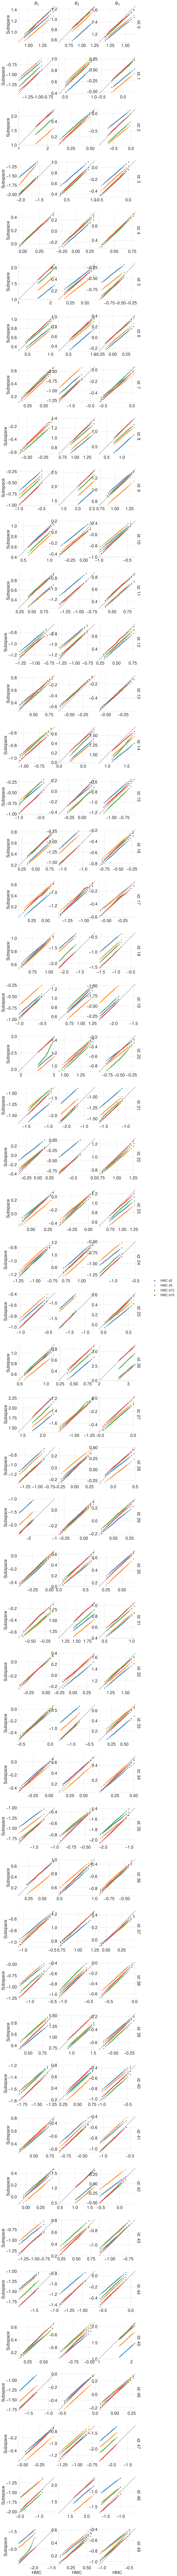

In [37]:
g = sns.FacetGrid(data=pd.concat(qq_plot_data_id), col='Dimension', row='Run', sharex=False, sharey=False, margin_titles=True, height=3)
g.map_dataframe(sns.scatterplot, x="HMC", y="Subspace", hue="Sampler")
for ax in g.axes_dict.values():
    xmin = np.vstack([ax.get_xlim(), ax.get_ylim()]).min()
    xmax = np.vstack([ax.get_xlim(), ax.get_ylim()]).max()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.axline((xmin, xmin), slope=1., c=".2", ls="--", zorder=0)
    ax.set_aspect("equal", "box")
g.set_titles(col_template="{col_name}", row_template="id: {row_name}")
g.add_legend()
g.tight_layout()
g.figure.subplots_adjust(wspace=0.1, hspace=0.1)